## Lesson preamble

### Lecture objectives

- Learn about tidy data.
- Transform data from the long to wide format.
- Understand which types of figures are suitable to create from raw data.
- Learn how to avoid common pitfalls when plotting large data sets.

### Lecture outline

- Reshaping with data with `pivot()`, `pivot_table()`, and `melt()` (40 min)
- Visualization tips and tricks
    - Choose informative plots for categorical data (35 min)
    - Changing plot appearance with `matplotlib` (35 min)
    - Avoiding saturated plots (40 min)
    - Making plots accessible through suitable color choices (10 min)

In [2]:
import pandas as pd
#if you don't have the dataset 
surveys = pd.read_csv('https://ndownloader.figshare.com/files/2292169')
#if you have already downloaded the dataset
#surveys = pd.read_csv('./surveys.csv')
surveys.head()

,record_id,month,day,year,plot_id,species_id,sex,hindfoot_length,weight,genus,species,taxa,plot_type
0,1,7,16,1977,2,NL,M,32.0,NaN,Neotoma,albigula,Rodent,Control
1,72,8,19,1977,2,NL,M,31.0,NaN,Neotoma,albigula,Rodent,Control
2,224,9,13,1977,2,NL,NaN,NaN,NaN,Neotoma,albigula,Rodent,Control
3,266,10,16,1977,2,NL,NaN,NaN,NaN,Neotoma,albigula,Rodent,Control
4,349,11,12,1977,2,NL,NaN,NaN,NaN,Neotoma,albigula,Rodent,Control


<!-- TODO I should talk about this during the data organization chapter also, maybe I can go into details, and this can be more like repetition? I shold mentioned splittign varibles. and to minimize storage space. -->

## Reshaping data between long and wide formats

Data is often presented in a so-called wide format, e.g. with one column per measurement:

|person|weight|height|age|
|------|------|------|---|
|A|70|170|32|
|B|85|179|28|

This can be a great way to display data so that it is easily interpretable by humans and is often used for summary statistics (commonly referred to as pivot tables). However, many data analysis functions in `pandas`, `seaborn` and other packages are optimized to work with the tidy data format. Tidy data is a long format where each row is a single observation and each column contains a single variable:

|person|measure|value|
|------|-----------|-----|
|     A|     weight|   70|
|     A|     height|  170|
|     A|        age|   32|
|     B|     weight|   85|
|     B|     height|  179|
|     B|        age|   28|

`pandas` enables a wide range of manipulations of the structure of data, including alternating between the long and wide format. The survey data presented here is in a tidy format. To facilitate visual comparisons of the relationships between measurements across variables, it would be beneficial to display this data in the wide format. For example, what is the relationship between mean weights of different species caught at the same plot type?

### Subset data

To make facilitate the visualization of the the transformations between wide and tidy data,  it is beneficial to create a subset of the data.

In [12]:
species_sub = ['albigula', 'flavus', 'merriami']
plot_id_sub = list(range(5, 11))
cols = ['record_id', 'species', 'weight', 'plot_type']
surveys_sub = surveys.loc[(surveys['plot_id'].isin(plot_id_sub)) & (surveys['species'].isin(species_sub)), cols]
surveys_sub.head(10)

,record_id,species,weight,plot_type
17415,465,albigula,NaN,Rodent Exclosure
17416,875,albigula,212.0,Rodent Exclosure
17417,2346,albigula,239.0,Rodent Exclosure
17418,3032,albigula,135.0,Rodent Exclosure
17419,4837,albigula,185.0,Rodent Exclosure
17420,5024,albigula,186.0,Rodent Exclosure
17421,5161,albigula,193.0,Rodent Exclosure
17422,5276,albigula,194.0,Rodent Exclosure
17423,5400,albigula,248.0,Rodent Exclosure
17424,5458,albigula,235.0,Rodent Exclosure


In [13]:
surveys_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2568 entries, 17415 to 34083
Data columns (total 4 columns):
record_id    2568 non-null int64
species      2568 non-null object
weight       2497 non-null float64
plot_type    2568 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 100.3+ KB


### Long to wide with `pivot()` and `pivot_table()`

A long to wide transformation would be suitable to effectively visualize the relationship between the mean body weights of each species within the different plot types used to trap the animals. The first step in creating this table is to compute the mean weight for each species in each plot type.

In [4]:
surveys_sub_gsp = (
    surveys_sub
        .groupby(['species', 'plot_type'])['weight']
        .mean()
        .reset_index()
)
surveys_sub_gsp

,species,plot_type,weight
0,albigula,Control,133.857143
1,albigula,Rodent Exclosure,185.342105
2,albigula,Short-term Krat Exclosure,179.933333
3,albigula,Spectab exclosure,161.818182
4,flavus,Control,7.056604
5,flavus,Rodent Exclosure,8.121951
6,flavus,Short-term Krat Exclosure,7.809524
7,flavus,Spectab exclosure,7.371429
8,merriami,Control,43.405405
9,merriami,Rodent Exclosure,42.964989


To remove the repeating information for 'species' and 'plot_type', this table can be pivoted into a wide formatted using the `pivot()` method. The arguments passed to `pivot()` includes the rows (the index), the columns, and which values should populate the table. 

In [5]:
surveys_sub_gsp.pivot(index='plot_type', columns='species', values='weight')

species,albigula,flavus,merriami
plot_type,,,
Control,133.857143,7.056604,43.405405
Rodent Exclosure,185.342105,8.121951,42.964989
Short-term Krat Exclosure,179.933333,7.809524,42.097674
Spectab exclosure,161.818182,7.371429,43.223270


Compare how this table is displayed with the table in the previous cell. It is certainly easier to spot differences between the species and plot types in this wide format.

Since presenting summary statistics in a wide format is such a common operation, `pandas` has a dedicated method, `pivot_table()`, that performs both the data aggregation pivoting.

In [6]:
surveys_sub.pivot_table(index='plot_type', columns='species', values='weight')

species,albigula,flavus,merriami
plot_type,,,
Control,133.857143,7.056604,43.405405
Rodent Exclosure,185.342105,8.121951,42.964989
Short-term Krat Exclosure,179.933333,7.809524,42.097674
Spectab exclosure,161.818182,7.371429,43.223270


Although `pivot_table()` is the most convenient way to aggregate *and* pivot data, `pivot()` is still useful to reshape a data frame from wide to long *without* performing aggregation.

With the data in a wide format, the pairwise correlations between the columns can be computed using `corr()`.

In [7]:
surveys_sub_pvt = surveys_sub.pivot_table(index='plot_type', columns='species', values='weight')
surveys_sub_pvt.corr()

species,albigula,flavus,merriami
species,,,
albigula,1.000000,0.958991,-0.680736
flavus,0.958991,1.000000,-0.589786
merriami,-0.680736,-0.589786,1.000000


The columns and rows can be swapped in the call to `pivot_table()`. This is useful both to present the table differently and to perform computations on a different axis (dimension) of the data frame (this result can also be obtained by calling the `transpose()` method of `subveys_sub`).

In [8]:
surveys_sub.pivot_table(index='species', columns='plot_type', values='weight')

plot_type,Control,Rodent Exclosure,Short-term Krat Exclosure,Spectab exclosure
species,,,,
albigula,133.857143,185.342105,179.933333,161.818182
flavus,7.056604,8.121951,7.809524,7.371429
merriami,43.405405,42.964989,42.097674,43.223270


With `pivot_table()` it is also possible to add the values for all rows and columns, and to change the aggregation function.

In [19]:
surveys_sub.pivot_table(index='plot_type', columns='species', values='weight', margins=True, aggfunc='median')

species,albigula,flavus,merriami,All
plot_type,,,,
Control,134.0,7.0,44.0,44.0
Rodent Exclosure,185.5,8.0,44.0,44.0
Short-term Krat Exclosure,178.0,8.0,43.0,40.0
Spectab exclosure,154.0,7.0,44.0,44.0
All,176.5,7.0,44.0,43.0


### Wide to long with `melt()`

It is also a common operation to reshape data from the wide to the long format, e.g. when getting the data into the most suitable format for analysis. For this transformation, the `melt()` method can be used to sweep up a set of columns into one key-value pair.

To prepare the data frame, the `plot_type` index name can be moved to a column name with the `reset_index()` method.

In [10]:
surveys_sub_pvt

species,albigula,flavus,merriami
plot_type,,,
Control,133.857143,7.056604,43.405405
Rodent Exclosure,185.342105,8.121951,42.964989
Short-term Krat Exclosure,179.933333,7.809524,42.097674
Spectab exclosure,161.818182,7.371429,43.223270


In [11]:
surveys_sub_pvt = surveys_sub_pvt.reset_index()
surveys_sub_pvt

species,plot_type,albigula,flavus,merriami
0,Control,133.857143,7.056604,43.405405
1,Rodent Exclosure,185.342105,8.121951,42.964989
2,Short-term Krat Exclosure,179.933333,7.809524,42.097674
3,Spectab exclosure,161.818182,7.371429,43.223270


At a minimum, `melt()` only requires the name of the column that should be kept intact. All remaining columns will have their values in the `value` column and their name in the `variable` column (here, our columns already has a name "species", so this will be used automatically instead of "variable").

In [12]:
surveys_sub_pvt.melt(id_vars='plot_type')

,plot_type,species,value
0,Control,albigula,133.857143
1,Rodent Exclosure,albigula,185.342105
2,Short-term Krat Exclosure,albigula,179.933333
3,Spectab exclosure,albigula,161.818182
4,Control,flavus,7.056604
5,Rodent Exclosure,flavus,8.121951
6,Short-term Krat Exclosure,flavus,7.809524
7,Spectab exclosure,flavus,7.371429
8,Control,merriami,43.405405
9,Rodent Exclosure,merriami,42.964989


To be more explicit, all the arguments to `melt()` can be specified. This way it is also possible to exclude some columns, e.g. the species 'merriami'.

In [13]:
surveys_sub_pvt.melt(id_vars='plot_type', value_vars=['albigula', 'flavus'], 
                     var_name='species', value_name='weight')

,plot_type,species,weight
0,Control,albigula,133.857143
1,Rodent Exclosure,albigula,185.342105
2,Short-term Krat Exclosure,albigula,179.933333
3,Spectab exclosure,albigula,161.818182
4,Control,flavus,7.056604
5,Rodent Exclosure,flavus,8.121951
6,Short-term Krat Exclosure,flavus,7.809524
7,Spectab exclosure,flavus,7.371429


#### Challenge

1. Make a wide data frame with `year` as columns, `plot_id` as rows, and the
values are the number of genera per plot. You will need to summarize before
reshaping, and use the function `nunique` to get the number of unique
types of a genus.

2. Now take that data frame, and make it long again, so each row is a unique
`plot_id` - `year` combination.

In [191]:
#Answer 1
genera_per_plot = surveys.groupby(['plot_id', 'year'])['genus'].nunique().reset_index()
genera_per_plot = genera_per_plot.pivot_table(index='plot_id', columns='year').reset_index()
genera_per_plot.head()

plot_id genus                                           ...             \
year          1977 1978 1979 1980 1981 1982  1983  1984 1985 ...  1993 1994   
0          1   2.0  3.0  4.0  7.0  5.0  6.0   7.0   6.0  4.0 ...   5.0  6.0   
1          2   6.0  6.0  6.0  8.0  5.0  9.0   9.0   9.0  6.0 ...   8.0  5.0   
2          3   5.0  6.0  4.0  6.0  6.0  8.0  10.0  11.0  7.0 ...   6.0  5.0   
3          4   4.0  4.0  3.0  4.0  5.0  4.0   6.0   3.0  4.0 ...   3.0  3.0   
4          5   4.0  3.0  2.0  5.0  4.0  6.0   7.0   7.0  3.0 ...   4.0  5.0   

                                              
year 1995 1996 1997 1998 1999 2000 2001 2002  
0     5.0  5.0  7.0  5.0  5.0  5.0  4.0  6.0  
1     6.0  7.0  7.0  5.0  6.0  7.0  7.0  7.0  
2     6.0  7.0  8.0  7.0  5.0  4.0  5.0  5.0  
3     4.0  6.0  8.0  4.0  4.0  5.0  5.0  5.0  
4     8.0  7.0  6.0  6.0  3.0  3.0  2.0  4.0  

[5 rows x 27 columns]

In [127]:
#other methods to get the same thing

# 1) 
#import numpy as np
#surveys.groupby(['plot_id', 'year'])['genus'].apply(lambda x: len(np.unique(x)))

# 2)  
#year_plot = surveys.groupby(['year', 'plot_id'])
#genus_perplot = year_plot.genus.nunique().reset_index()
#genus_perplot.pivot_table(index='plot_id', columns='year')



In [190]:
# Answer 2
genera_per_plot.melt(id_vars='plot_id').head()

,plot_id,None,year,value
0,1,genus,1977,2.0
1,2,genus,1977,6.0
2,3,genus,1977,5.0
3,4,genus,1977,4.0
4,5,genus,1977,4.0


In [192]:
# or 
genera_per_plot.melt(id_vars='plot_id', value_name='genus').head()

,plot_id,None,year,genus
0,1,genus,1977,2.0
1,2,genus,1977,6.0
2,3,genus,1977,5.0
3,4,genus,1977,4.0
4,5,genus,1977,4.0


In [200]:
# Answer 3
#foot_and_weight = surveys.loc[:,['hindfoot_length', 'weight']]
surveys.melt(id_vars = ''


,variable,value
0,hindfoot_length,32.0
1,hindfoot_length,31.0
2,hindfoot_length,NaN
3,hindfoot_length,NaN
4,hindfoot_length,NaN


In [199]:
foot_and_weight.melt().tail()

,variable,value
69567,weight,16.0
69568,weight,22.0
69569,weight,8.0
69570,weight,NaN
69571,weight,NaN


# Visualization tips and tricks

## Choose informative plots for categorical data

When visualizing data it is important to explore different plotting options and reflect on which one best conveys the information within the data. In the following code cells, as sample data set is used to illustrate some advantages and disadvantages between categorical plot types. This sample data contains three different species of iris flowers and measurements of their sepals and petals.

In [21]:
import seaborn as sns

iris = sns.load_dataset('iris')
iris.groupby('species').mean()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
setosa,5.006,3.428,1.462,0.246
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


### Bar plots

A common visualization when comparing a groups is to create a barplot of the means of each group and plot them next to each other.

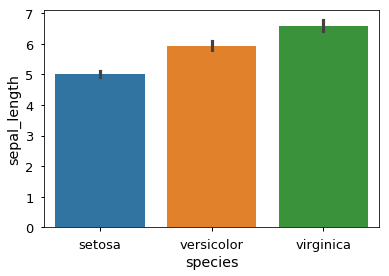

In [29]:
%matplotlib inline

sns.set_context('notebook', font_scale=1.3)
sns.barplot(x='species', y='sepal_length', data=iris)

### Box plots

Another way of visualizing this comparison would be to supplement a measure of central tendency, such as the mean or median, with additional population statistics. This is what can be seen in the boxplot, as described in the previous lecture.

Text(0.5,0,'')

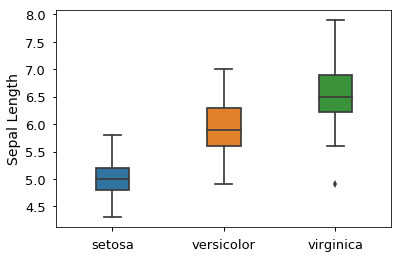

In [36]:
ax = sns.boxplot(x='species', y='sepal_length', data=iris, width=0.3)
ax.set_ylabel('Sepal Length', fontsize=14)
ax.set_xlabel('')

### Violin plots

A violin plot approximates the distribution of the data through a smoothened histogram. The graphics in the middle of the plot represent a boxplot.

Text(0.5,0,'')

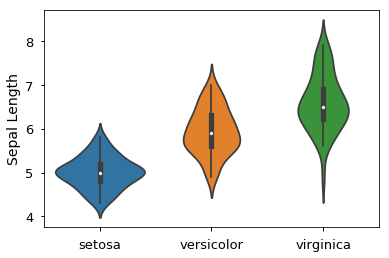

In [17]:
ax = sns.violinplot(x='species', y='sepal_length', data=iris)
ax.set_ylabel('Sepal Length', fontsize=14)
ax.set_xlabel('')
# ax.set_xticklabels(fontsize=20)

### Swarm plots

Swarm plots draws every single observation and stacks like a histogram. 

Text(0.5,0,'')

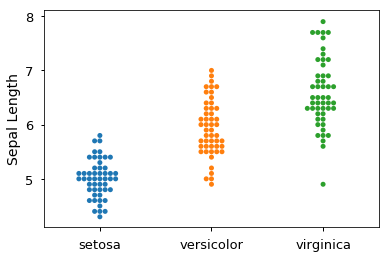

In [18]:
ax = sns.swarmplot(x='species', y='sepal_length', data=iris)
ax.set_ylabel('Sepal Length', fontsize=14)
ax.set_xlabel('')

>#### Challenge
>
>Out of the these plots, which one do you think is the most
>informative and why? Which is the most true to the underlying data and how
>would you know this?

### Pros and cons of different graph types

We will deepen the discussion around some of these ideas, in the context of the
following plot:

![*Reproduced with permission from [Dr. Koyama's poster](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/TatsukiKoyama/Poster3.pdf)*](./img/dynamite-bars.png)

*Reproduced with permission from [Dr. Koyama's poster](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/TatsukiKoyama/Poster3.pdf)*

It is generally advisable to avoid "decorative" plot elements that do not convey extra information about the data, *especially* when such elements hide the real data. An early champion of this idea was Edward Tufte, who details how to reduce so called non-data ink and many other things in his book [The visual display of quantitative information](https://www.edwardtufte.com/tufte/books_vdqi). In the bar chart above, the only relevant information is given by the where the rectangles of the bars ends on the y-axis, the rest of it is unnecessary. Instead of using the rectangle's height, a simpler marker (circle, square, etc) could have been used to indicate the height on the y-axis. Note that the body of the rectangle is not representative for where the data lies, there are probably no data points close to 0, and several above the rectangle.

Barplots are especially misleading when used as data summaries, as in the
example above. In a summary plot, only two distribution parameters (a measure of
central tendency, e.g. the mean, and error, e.g. the standard deviation or a
confidence interval) are displayed, instead of showing all the individual data
points. This can be highly misleading, since different underlying distributions
can give rise to the same summary plot. We also have no idea of how many observations there are in each group. These
shortcomings become evident when comparing the barplot to the underlying
distributions that were used to create them:

![*Reproduced with permission from [Dr. Koyama's poster*](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/TatsukiKoyama/Poster3.pdf)](./img/dynamite-vs-dists.png)

*Reproduced with permission from [Dr. Koyama's poster](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/TatsukiKoyama/Poster3.pdf)*

Immediately, you can see that conclusions drawn from the barplot, such that A
and B have the same outcome, are factually incorrect. The distribution in D is
bimodal, so representing that with a mean would be like observing black and
white birds and conclude that the average bird color is grey, it's nonsensical.
If we would have planned our follow up experiments based on the barplot alone,
we would have been setting ourselves up for failure! Always be sceptical when
you see a barplot in a published paper, and think of how the underlying
distribution might look (note that barplots are more acceptable when used to
represents counts, proportion or percentages, where there is only one data point
per group in the data set).

Boxplots and violin plots are more meaningful data summaries as they represent more than just two distribution parameters (such as mean +/- sd). However, these can still be misleading and it is often the most appropriate to show each individual observation with a dot/hive/swarm plot, possibly combined with a superimposed summary plot or a marker for the mean or median *if* this additional information is useful. One exception, when it is not advisable to show all data points, is when the data set is gigantic and plotting each individual observation would oversaturate the chart. In that case, plot summary statistics or a 2D histogram (more on this later).

Here is an example of how a violinplot can be combined together with the individual observations in `seaborn`.

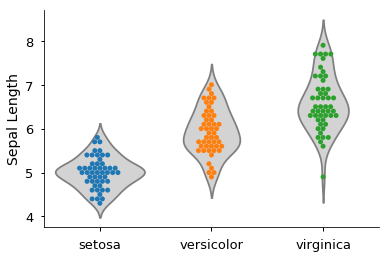

In [19]:
ax = sns.violinplot(x='species', y='sepal_length', data=iris, color='lightgrey', inner=None)
ax = sns.swarmplot(x='species', y='sepal_length', data=iris) 
ax.set_ylabel('Sepal Length', fontsize=14)
ax.set_xlabel('')
sns.despine()

>#### Challenge
>
>1. So far, we've looked at the distribution of sepal length within species.  Try making a new plot to explore the distribution of another variable within each species.
>2. Combine a `stripplot()` with a `boxplot()`. Set the `jitter` parameter to distribute the dots so that they are not all on one line.

## Changing plot appearance with `matplotlib`

The knowledge of how to make an appealing and informative visualization can be put into practice by working directly with `matplotlib`, and styling different elements of the plot. The high-level figures created by `seaborn` can also be configured via the `matplotlib` parameters, so learning more about them will be very useful.

As demonstrated previously with `seaborn.FacetGrid`, one way of creating a line plot in matplotlib is by using `plt.plot()`. To facilitate the understanding of these concepts, the initial examples will not include data frames, but instead have simple lists holding just a few data points. This is how a line plot can be created with `matplotlib`.

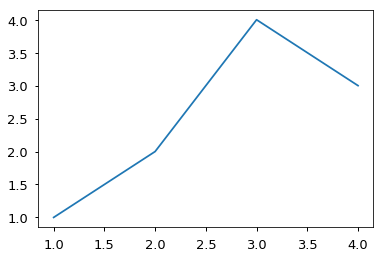

In [28]:
import matplotlib.pyplot as plt

x = [1, 2, 3, 4]
y = [1, 2, 4, 3]
plt.plot(x ,y)

However, this way of plotting is not very explicit, since some things happen under the hood that we can't control, e.g. a figure is automatically created and it is assumed that the plot should go into the currently active region of this figure. This gives little control over exactly where to place the plots within a figure and how to make modifications the plot after creating it, e.g. adding a title or label the axis. For these operations, it is easier to use the object oriented plotting interface, where an empty figure and is created initially. This figure and its axes are assigned to variable names which are then explicitly used for plotting. In m`matplotlib`, an axes refers to what you would often call a subplot colloquially and it is named "axes" because it consists of an x-axis and a y-axis by default. By default an empty figure is created.

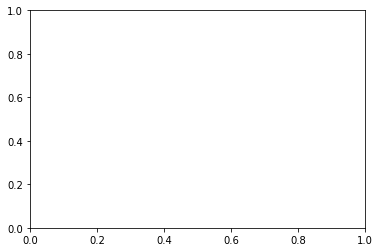

In [29]:
fig, ax = plt.subplots()

Plots can then be added to the axes of the figure.

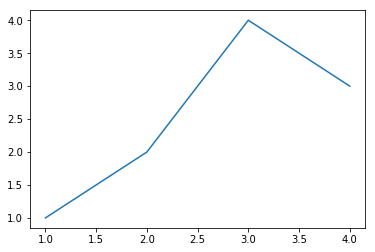

In [21]:
fig, ax = plt.subplots()
ax.plot(x, y)

To create a scatter plot, use `ax.scatter()` instead of `ax.plot()`.

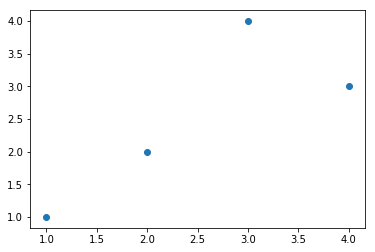

In [30]:
fig, ax = plt.subplots()
ax.scatter(x, y)

Plots can also be combined together in the same axes. The line style and marker color can be changed to facilitate viewing the elements in th combined plot.

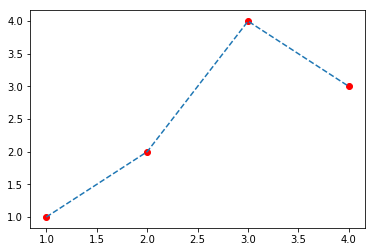

In [17]:
fig, ax = plt.subplots()
ax.scatter(x, y, color='red')
ax.plot(x, y, linestyle='dashed')

And plot elements can be resized.

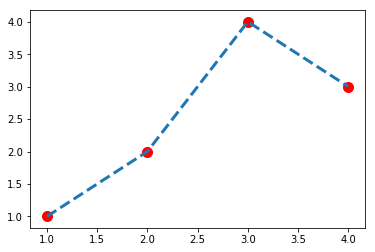

In [22]:
fig, ax = plt.subplots()
ax.scatter(x, y, color='red', s=100)
ax.plot(x, y, linestyle='dashed', linewidth=3)

It is common to modify the plot after creating it, e.g. adding a title or label the axis.

Text(0.5,0,'Measurement X')

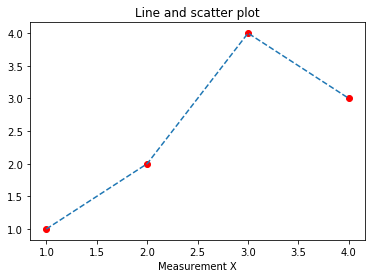

In [23]:
fig, ax = plt.subplots()
ax.scatter(x, y, color='red')
ax.plot(x, y, linestyle='dashed')

ax.set_title('Line and scatter plot')
ax.set_xlabel('Measurement X')

The scatter and line plot can easily be separated into two subplots within the same figure. Instead of assigning a single returned axes to `ax`, the two returned axes objects are assigned to `ax1` and `ax2` respectively.

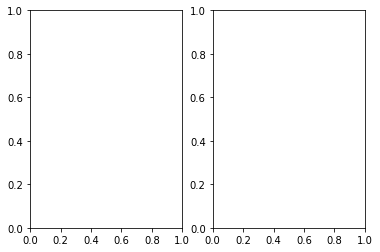

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2) # The default is (1, 1), that's why it does not need to be specified with only one subplot

To prevent plot elements, such as the axis ticklabels from overlapping, `tight_layout()` method can be used.

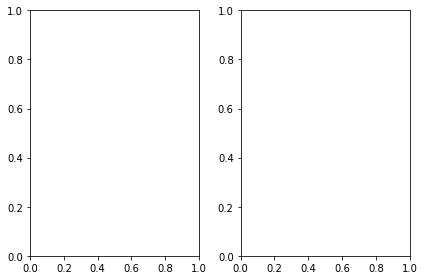

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout()

The figure size can easily be controlled when it is created.

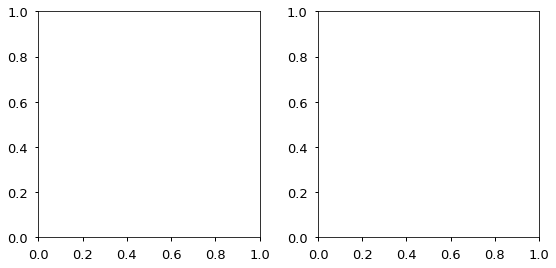

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4)) # This refers to the size of the figure in inches when printed or in a PDF
fig.tight_layout()

Putting it all together to separate the line and scatter plot.

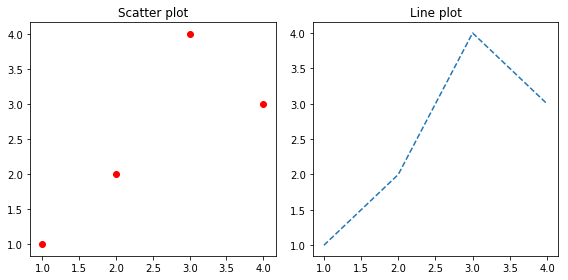

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.scatter(x, y, color='red')
ax2.plot(x, y, linestyle='dashed')

ax1.set_title('Scatter plot')
ax2.set_title('Line plot')
fig.tight_layout()

> #### Challenge
> 
> There are a plethora of colors available to use in `matplotlib`. Change the color of the line and the dots in the figure using [your favorite color from this list](https://stackoverflow.com/a/37232760/2166823). Use the documentation to also change the styling of the line in the line plot and the type of marker used in the scatter plot (you might need an online search also).

### Saving graphs

Figures can be saved by calling the `savefig()` method and specifying the name of file to create. The resolution of the figure can be controlled by the `dpi` parameter.

In [31]:
fig.savefig('scatter-and-line.png', dpi=300)

A PDF-file can be saved by changing the extension in the specified file name. Since PDF is a vector file format, there is not need to specify the resolution.

In [32]:
fig.savefig('scatter-and-line.pdf')

This concludes the customization section. The concepts taught here will be applied in the next section on how to choose a suitable plot type for data sets with many observations.

## Avoiding saturated plots

Summary plots (especially bar plots) were previously mentioned to potentially be misleading, and it is often most appropriate to show every individual observation with a dot plot or the like, perhaps combined with summary markers where appropriate. But, what if the data set is too big to visualize every single observations? In large data sets, it is often the case that plotting each individual observation would oversaturate the chart.  

To illustrate saturation and how it can be avoided, load the datasets `diamonds` from the R sample data set repository:

In [41]:
diamonds = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/ggplot2/diamonds.csv', index_col=0)
diamonds.tail()

,carat,cut,color,clarity,depth,table,price,x,y,z
53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74
53940,0.75,Ideal,D,SI2,62.2,55.0,2757,5.83,5.87,3.64


In [34]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
carat      53940 non-null float64
cut        53940 non-null object
color      53940 non-null object
clarity    53940 non-null object
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


When plotting a data frame, `matplotlib` is aware of the structure of the data by specifying the `data` parameter and the `x` and `y` parameters can then be specified just by passing the name of a column in the data frame as a string.

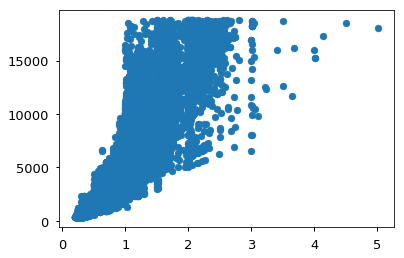

In [35]:
fig, ax = plt.subplots()
ax.scatter('carat', 'price', data=diamonds)

Because this is a dataset with 53940 observations, visualizing it in two dimensions creates a graph that is incredibly oversaturated. Oversaturated graphs make it *far more* difficult to glean information from the visualization. Maybe adjusting the size of each observation could help?

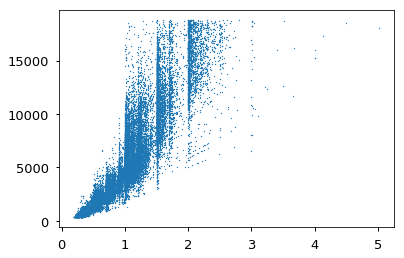

In [36]:
fig, ax = plt.subplots()
ax.scatter('carat', 'price', data=diamonds, s=1)

That's a bit better. Reducing the transparency might help further.

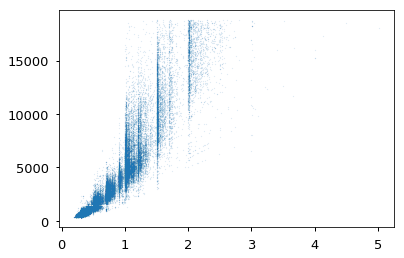

In [37]:
fig, ax = plt.subplots()
ax.scatter('carat', 'price', data=diamonds, s=1, alpha=0.1)

This is much clearer than initially, but does still not reveal the full structure of the underlying data. Before proceeding, add axis labels and remove the axis lines (spines) on the top and the right.

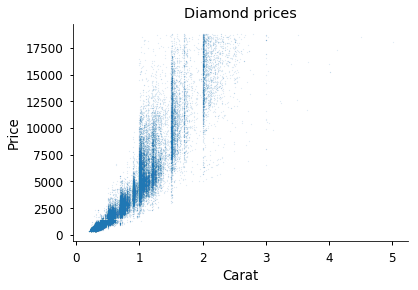

In [45]:
fig, ax = plt.subplots()
ax.scatter('carat', 'price', data=diamonds, s=1, alpha=0.1)

sns.set_context('notebook', font_scale=1.2) # Increase all font sizes
ax.set_title('Diamond prices')
ax.set_xlabel('Carat')
ax.set_ylabel('Price')
sns.despine()# sns.despine() essentially does the following:
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

The axis can be adjusted to zoom in on the denser areas in the plot.

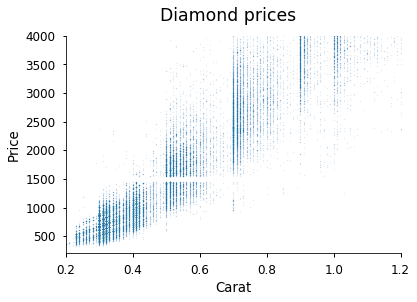

In [39]:
fig, ax = plt.subplots()
ax.scatter('carat', 'price', data=diamonds, s=1, alpha=0.1)

fig.suptitle('Diamond prices')
ax.set_xlabel('Carat')
ax.set_ylabel('Price')
ax.set_xlim(0.2, 1.2)
ax.set_ylim(200, 4000)
sns.despine()

The result is still not satisfactory, which illustrates that the scatter plot is simply not a good choice with huge data sets. A more suitable plot type for this data, is a so called `hexbin` plot, which essentially is a two dimensional histogram, where the color of each hexagonal bin represents the amount of observations in that bin (analogous to the height in a one dimnesional histogram). 

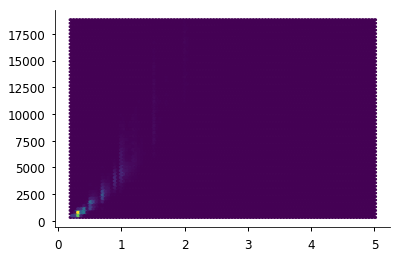

In [40]:
fig, ax = plt.subplots()
ax.hexbin('carat', 'price', data=diamonds)
sns.despine()

This looks ugly because the bins with zero observations are still colored. This can be avoided by setting the minimum count of observations to color a bin.

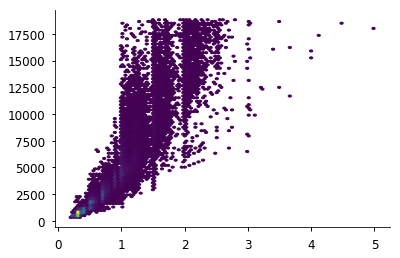

In [41]:
fig, ax = plt.subplots()
ax.hexbin('carat', 'price', data=diamonds, mincnt=1)
sns.despine()

The distribution of the data is not more akin to that of the scatter plot. To know what the different colors represent, a colorbar needs to be added to this plot. The space for the colorbar will be taken from a plot in the current figure.

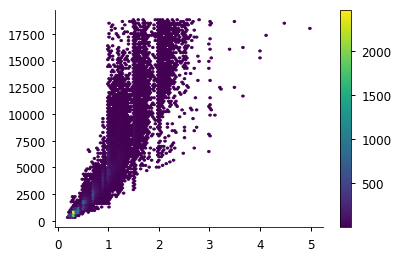

In [42]:
fig, ax = plt.subplots()
# Assign to a variable to reuse with the colorbar
hex_plot = ax.hexbin('carat', 'price', data=diamonds, mincnt=1)
sns.despine()
# Create the colorbar from the hexbin plot axis
cax = fig.colorbar(hex_plot)

Notice that the overall figure is the same size, and the axes that contains the hexbin plot shrank to make room for the colorbar. To remind ourselves what is plotted, axis labels can be added like previously.

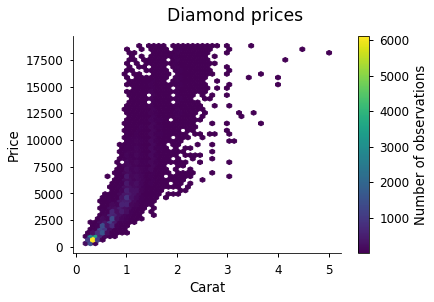

In [43]:
fig, ax = plt.subplots()
hex_plot = ax.hexbin('carat', 'price', data=diamonds, mincnt=1, gridsize=50)
sns.despine()
cax = fig.colorbar(hex_plot)

fig.suptitle('Diamond prices')
ax.set_xlabel('Carat')
ax.set_ylabel('Price')
cax.set_label('Number of observations')

It is now clear that the yellow area represents over 2000 observations!

Text(0,0.5,'Price')

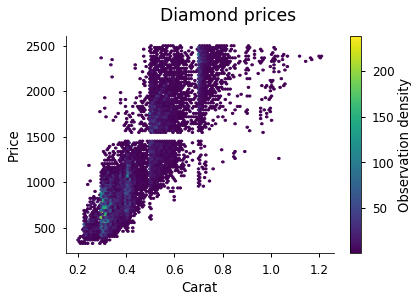

In [44]:
fig, ax = plt.subplots()

fig.suptitle('Diamond prices')
diamonds_subset = diamonds.loc[(diamonds['carat'] < 1.3) & (diamonds['price'] < 2500)]
hexbin = ax.hexbin('carat', 'price', data=diamonds_subset, mincnt=1)
sns.despine()
cax = fig.colorbar(hexbin)
cax.set_label('Observation density')
ax.set_xlabel('Carat')
ax.set_ylabel('Price')


Although this hext plot is a great way of visualizing the distributions, it can also be good to look at the histograms.

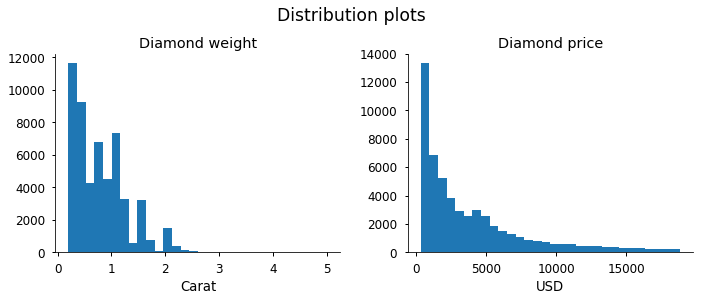

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Distribution plots', y=1.05)

ax1.hist('carat', bins=30, data=diamonds) 
ax1.set_title('Diamond weight')
ax1.set_xlabel('Carat')

ax2.hist('price', bins=30, data=diamonds) 
ax2.set_title('Diamond price')
ax2.set_xlabel('USD')

sns.despine()
fig.tight_layout()

Since this is a common operation, `seaborn` has a built-in function to create a hexbin with histograms on the marginal axes.

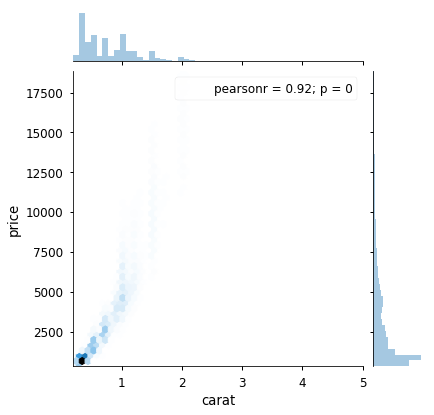

In [46]:
sns.jointplot(x='carat', y='price', data=diamonds, kind='hex')

This can be customized to appear like the previous hexbin plots. Since `joinplot()` deals with both the hexbin and the histogram, the parameter names must be separated so that it is clear which plot they are referring to. This is done by passing them as dictionaries to the `joint_kws` and `marginal_kws` parameters ("kws" stands for "keywords").

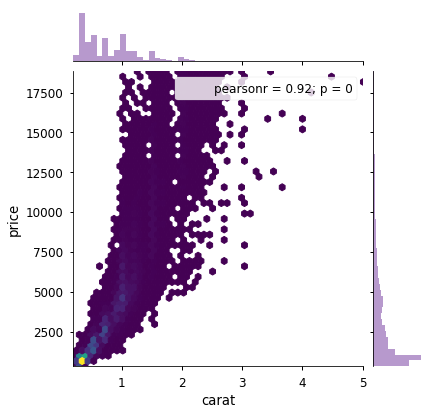

In [47]:
sns.jointplot('carat', 'price', diamonds, kind='hex', 
              joint_kws={'cmap':'viridis', 'mincnt':1},
              marginal_kws={'color': 'indigo'})

## Making plots accessible through suitable color choices

Colour blindness is common in the population, and red-green colour blindness in particular affects 8% of men and 0.5% of women. Guidelines for making your visualizations more accessible to people affected by colour blindness, will in many cases also improve the interpretability of your graphs for people who have standard color vision. Here are a couple of examples:

Don't use jet rainbow-coloured heatmaps. Jet colourmaps are often the default heatmap used in many visualization packages (you've probably seen them before). 

![](./img/heatmap.png)

Colour blind viewers are going to have a difficult time distinguishing the meaning of this heat map if some of the colours blend together.

![](./img/colourblind.png)

The jet colormap should be avoided for other reasons, including that the sharp transitions between colors introduces visual threshold levels that do not represent the underlying continuous data. Another issue is luminance, or brightness. For example, your eye is drawn to the yellow and cyan regions, because the luminance is higher. This can have the unfortunate effect of highlighting features in your data that don't actually exist, misleading your viewers! It also means that your graph is not going to translate well to greyscale in publication format.

More details about jet can be found in [this blog post](https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/) and [this series of posts](https://mycarta.wordpress.com/2012/05/12/the-rainbow-is-dead-long-live-the-rainbow-part-1/). In general, when presenting continuous data, a perceptually uniform colormap is often the most suitable choice. This type of colormap ensures that equal steps in data are perceived as equal steps in color space. The human brain perceives changes in lightness as changes in the data much better than, for example, changes in hue. Therefore, colormaps which have monotonically increasing lightness through the colormap will be better interpreted by the viewer. More details and examples of such colormaps are available in the [matplotlib documentation](http://matplotlib.org/users/colormaps.html), and many of the core design principles are outlined in [this entertaining talk](https://www.youtube.com/watch?v=xAoljeRJ3lU).

Another approach is to use both colours and symbols. 

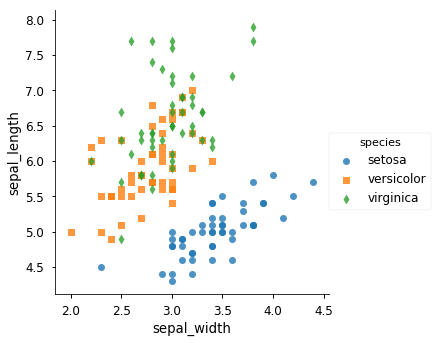

In [48]:
sns.lmplot(x='sepal_width', y='sepal_length', hue='species', data=iris,
           fit_reg=False, markers=['o', 's', 'd'])

Or to change the color palette

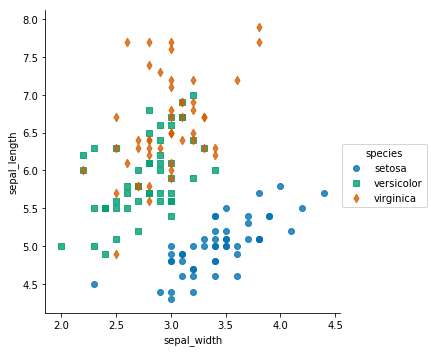

In [74]:
# To see all available palettes, set it to an empty string and see the error message
sns.lmplot(x='sepal_width', y='sepal_length', hue='species', data=iris,
           fit_reg=False, markers=['o', 's', 'd'], palette='colorblind')

>#### Challenge
>
>Create any coloured figure you want and go to  [this](http://www.color-blindness.com/coblis-color-blindness-simulator/)  website to upload it to see how it  looks to a colour blind person 
>
>For more resources, [here](http://blog.usabilla.com/how-to-design-for-color-blindness/) is a great usability article for designing for people with colour blindness.

### More general resources on plotting

* [Ten Simple Rules for Better Figures](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003833)
* [Finding the Right Color Palettes for Data Visualizations](https://blog.graphiq.com/finding-the-right-color-palettes-for-data-visualizations-fcd4e707a283)
* [Examples of bad graphs](https://www.biostat.wisc.edu/~kbroman/topten_worstgraphs/)
* [More examples of bad graphs and how to improve them](https://www.stat.auckland.ac.nz/~ihaka/120/Lectures/lecture03.pdf)
* [Wikipedia has a great article on misleading graphs](https://en.wikipedia.org/wiki/Misleading_graph)